## 3. Principal Component Analysis

### 3.1. Load libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import*
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap

import seaborn as sns

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, FactorRange
from bokeh.io import show, output_file
from bokeh.models.tickers import FixedTicker
from bokeh.models import Arrow, OpenHead, NormalHead, VeeHead

from pprint import pprint

In [3]:
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy import stats
from scipy.stats import pearsonr

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA

### 3.2. Functions

In [5]:
# For labeling purpose. Create a list of PCx or Principal Component x
def pc(num, lng):
    if lng == 0:
        prefix = 'PC'
    else:
        prefix = 'Principal Component '
    pc_list = []
    for i in np.arange(1, num+1):
        pric = prefix+str(i)
        pc_list.append(pric)
    return pc_list

In [6]:
# Expected Proportion of the kth Largest Piece
# Adobted from https://blogs.sas.com/content/iml/2017/08/02/retain-principal-components.html

def exprop(n):
    ex_list = []
    for i in np.arange(1,n+1):
        tempsum = 0
        for j in np.arange(i, n+1):
            tempsum = tempsum + (1/j)
        cor = 100*tempsum/n
        ex_list.append(cor)
    return ex_list

### 3.3. Read data from spreadsheet

In [7]:
raw_input = pd.read_csv('data/cleaned.csv', index_col='County')

In [8]:
metrics = list(raw_input.columns)
counties = list(raw_input.index)
# print(len(metrics), len(counties))

### 3.4. Step for PCA

In [9]:
# Create scaler: scaler
scaler = StandardScaler()

# Fit the pipeline to 'samples'
scaler_df = pd.DataFrame(scaler.fit_transform(raw_input))

# Feature and Counties
scaler_df.columns = metrics
scaler_df.index = counties

# Covariance matrix
cov_df = pd.DataFrame(np.cov(scaler_df.T))

cov_df.index = metrics
cov_df.columns = metrics

# Perform eigendecomposition on covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_df)

# Eigenvalues in dataframe
eigvals_df=pd.DataFrame(eig_vals)
eigvals_df.columns = ['Eigenvalue']
eigvals_df.index = pc(eigvals_df.shape[0], 1)


# Eigenvectors in dataframe
eigvecs_df=pd.DataFrame(eig_vecs)
eigvecs_df.columns=pc(eig_vecs.shape[1],0)
eigvecs_df.index = metrics


# Create a PCA model with 30 components: the count of useful PCs will be selected later
pca = sklearnPCA(n_components=30)

# Fit the PCA instance to the scaled samples
pca.fit(scaler_df)

# Transform the scaled samples: pca_features
pca_features = pca.transform(scaler_df)

#### Correlation matrix heatmap

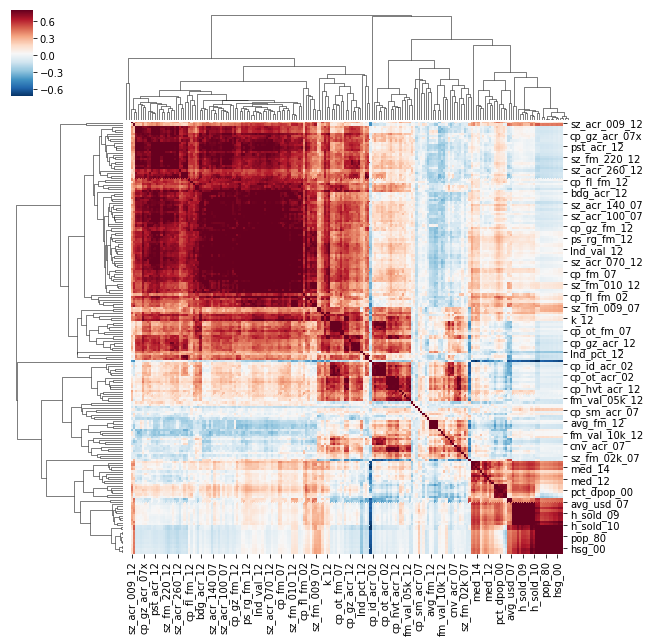

In [11]:
corrmat = scaler_df.corr()
sns.clustermap(corrmat, vmax=.8, square=True, cmap="RdBu_r");
plt.show()

#### p-values for correlation matrix

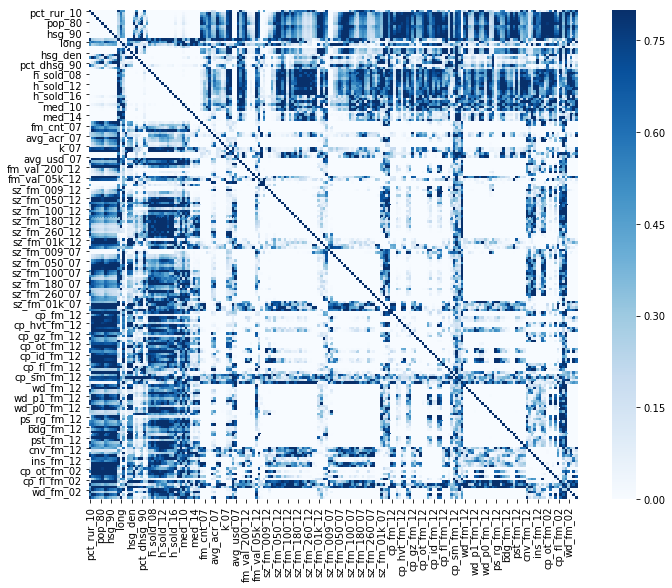

In [64]:
rows, cols = scaler_df.shape[0], scaler_df.shape[1]
rmat = np.ones(shape=(cols, cols))
pmat = np.ones(shape=(cols, cols))
for i in range(cols):
    for j in range(i+1, cols):
        r, p = pearsonr(scaler_df.iloc[:,i], scaler_df.iloc[:,j])
        rmat[i, j] = rmat[j, i] = r
        pmat[i, j] = pmat[j, i] = p

rmat_df = pd.DataFrame(rmat)
pmat_df = pd.DataFrame(pmat)

pmat_df.index = metrics
pmat_df.columns = metrics
pmat_df

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(pmat_df, vmax=.8, square=True, cmap="Blues");
plt.show()

#### Scree Plot

In [10]:
# Scree plot values: determine how many components sufficiently explain variations.
# Expected Proportion of the kth Largest Piece
# Adobted from https://blogs.sas.com/content/iml/2017/08/02/retain-principal-components.html


vari= eigvals_df=pd.DataFrame(100* pca.explained_variance_ratio_)
vari['1'] = ''
vari['2'] = ''
vari.iloc[0,1] = vari.iloc[0,0]
vari.iloc[0,2] = eig_vals[0].real
for i in np.arange(1, vari.shape[0]):
    vari.iloc[i,1] = vari.iloc[i,0] + vari.iloc[i-1,1]
    vari.iloc[i,2] = eig_vals[i].real
    
vari.columns = ['Exp. Variance (%)', 'Cumulative (%)', 'Eigenvalue']
vari.index = pc(vari.shape[0],0)
vari['Broken Stick Threshold'] = exprop(vari.shape[0])
#vari

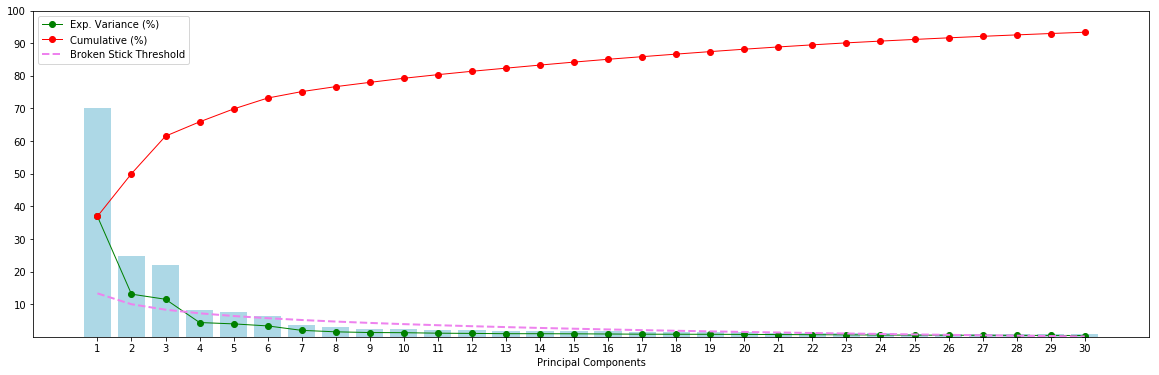

In [12]:
# Scree Plot

# drawing charts and labels

plt.rcParams["figure.figsize"] = [20,6]

exvar = plt.plot(np.arange(1, vari.shape[0]+1),vari['Exp. Variance (%)'], color = 'green', linewidth = 1, marker ='o')
acvar = plt.plot(np.arange(1, vari.shape[0]+1),vari['Cumulative (%)'], color='red', linewidth = 1, marker ='o' )
br_st = plt.plot(np.arange(1, vari.shape[0]+1),vari['Broken Stick Threshold'], color = 'violet', linewidth = 2, linestyle="--")
eival = plt.bar(np.arange(1, vari.shape[0]+1),vari['Eigenvalue'], color = 'lightblue')


plt.xlabel('Principal Components')
plt.xticks(np.arange(1, vari.shape[0]+1))
plt.yticks(np.arange(10, 110, 10))

# first_legend = plt.legend(handles=[exvar,first_legend],loc=1)
# ax = plt.gca().add_artist(first_legend)
plt.legend()
# plt.legend(handles=[eival,first_legend])
plt.show()

In [11]:
# This line filters significant according to broken stick method. (PCs 28-30 are probably neglible)

vari[vari['Exp. Variance (%)'] > vari['Broken Stick Threshold']]

,Exp. Variance (%),Cumulative (%),Eigenvalue,Broken Stick Threshold
PC1,36.931857,36.9319,70.1705,13.316624
PC2,13.080779,50.0126,24.8535,9.983290
PC3,11.508304,61.5209,21.8658,8.316624
PC28,0.436514,92.5629,0.829376,0.345101
PC29,0.423037,92.9859,0.80377,0.226054
PC30,0.395436,93.3813,0.751328,0.111111


In [13]:
# Based on scree plot result, the dataframe contains 3 PCs for the counties

pcaft_df = pd.DataFrame(pca_features)
pcaft_df.columns = pc(pcaft_df.shape[1],0)
pcaft_df.index = counties
pcaft_df.drop(list(pcaft_df.columns[np.arange(3,pcaft_df.shape[1])]), axis=1, inplace=True)

In [14]:
# Share of features in PCs

pcacom_df = pd.DataFrame(pca.components_.T)
pcacom_df.columns = pc(pcacom_df.shape[1],0)
pcacom_df.index = metrics
pcacom_df.drop(list(pcacom_df.columns[np.arange(3,pcacom_df.shape[1])]), axis=1, inplace=True)

In [18]:
# pcaft_df.to_csv('data/plots.csv') 
# pcacom_df.to_csv('data/vectors.csv') 